# Imports

In [1]:
import tarfile
import numpy as np

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
from scipy.io import readsav

In [4]:
import os

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model


In [6]:
import sunpy
import sunpy.map

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    mode='min'
)

# Useful General Functions

In [9]:
def get_file_paths(directory_path):
    """
    Given a directory path, this function returns a list of full file paths
    for all the files within the given directory.

    Parameters:
    - directory_path (str): The path to the directory from which to list files.

    Returns:
    - List[str]: A list of full file paths.
    """
    # List to hold file paths
    file_paths = []

    # Check if the directory exists
    if not os.path.isdir(directory_path):
        raise ValueError(f"The provided directory path does not exist: {directory_path}")

    # Walk the directory tree
    for root, _, files in os.walk(directory_path):
        for file in files:
            # Concatenate the root directory and file name to get the full path
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

"""
# Test
im = get_file_paths("G:\\BMR_Identification")
img = image_data_generator(im)
image = next(img)

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()
"""

'\n# Test\nim = get_file_paths("G:\\BMR_Identification")\nimg = image_data_generator(im)\nimage = next(img)\n\nplt.figure(figsize=(10, 10))\nplt.imshow(image, cmap=\'gray\', origin=\'lower\')\nplt.colorbar()\nplt.title(\'Image Data from IDL .sav file\')\nplt.show()\n'

In [10]:
def combined_generator(x_generator, y_generator, batch_size):
    while True:  # Loop indefinitely
        X_batch = []
        Y_batch = []
        
        for _ in range(batch_size):
            X_batch.append(next(x_generator))
            Y_batch.append(next(y_generator))
        
        # Convert to numpy arrays and yield the batches
        yield (np.array(X_batch), np.array(Y_batch))


# Sun Images

In [11]:
def load_fits_image_sunpy(fits_file_path, vmin=-1500, vmax=1500):
    # Use sunpy to open the FITS file
    magnetogram_map = sunpy.map.Map(fits_file_path)
    image_data = magnetogram_map.data.astype(np.float32)  # Ensure data is in float32
    
    # Clip the data to be within the range [vmin, vmax]
    image_data = np.clip(image_data, vmin, vmax)
    
    # Normalize the clipped image data to [0, 1]
    image_data = (image_data - vmin) / (vmax - vmin)
    
    image_data = np.nan_to_num(image_data, nan=0)
    return image_data

def sun_data_generator(file_paths):
    while True:
        for file_path in file_paths:
            yield load_fits_image_sunpy(file_path)

0.50905


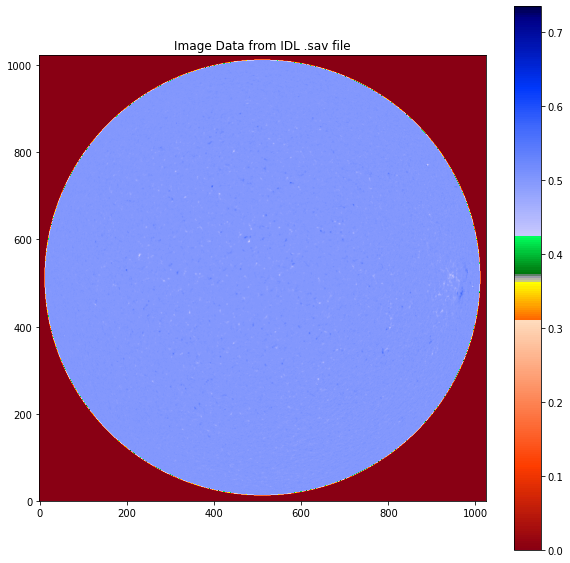

In [17]:
# Test
im = get_file_paths("G:\\Train\\X_train")
img = sun_data_generator(im)
image = next(img)
print(image[512][512])
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='hmimag', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()

# BMR Images

In [18]:
def process_sav_file(sav_file_path):
    # Read the .sav file
    idl_data = readsav(sav_file_path)
    
    # Extract image dimensions and indices
    hdr_los = idl_data['hdr_los']
    naxis1 = hdr_los.naxis1[0]
    naxis2 = hdr_los.naxis2[0]
    bmr_ind = idl_data['bmr_ind']
    
    # Convert flat indices to 2D indices
    rows, cols = np.divmod(bmr_ind, naxis1)

    # Create an empty image and set the magnetic regions to 1
    image_data = np.zeros((naxis2, naxis1), dtype=np.float32)
    image_data[rows, cols] = 1.0
    
    image_data = np.expand_dims(image_data, axis=-1)

    return image_data

def image_data_generator(file_paths):
    while True:
        for file_path in file_paths:
            yield process_sav_file(file_path)

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


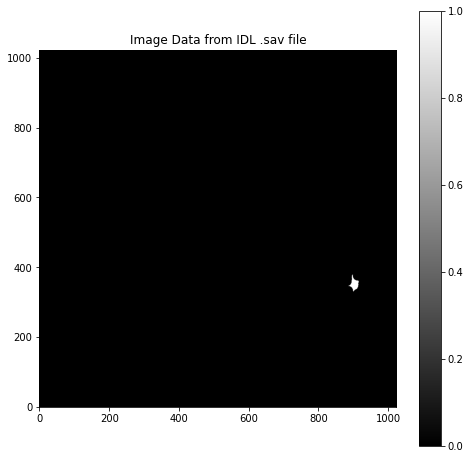

In [19]:
# Test
im = get_file_paths("G:\\BMR_Identification")
img = image_data_generator(im)
image = next(img)
print(image)
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()



# Model

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Lambda, Cropping2D
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

def create_small_unet(input_size=(1024, 1024, 1), pretrained_weights=None):
    inputs = Input(input_size)
    x = Lambda(lambda x: tf.tile(x, multiples=[1, 1, 1, 3]))(inputs)  # Convert to RGB

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x, input_shape=(1024, 1024, 3))

    # Freeze the layers of MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False

    # Define the layer names for skip connections
    layer_names = [
        "block_1_expand_relu",   # downsampled to 512x512
        "block_3_expand_relu",   # downsampled to 256x256
        "block_6_expand_relu",   # downsampled to 128x128
        # Add the additional layers needed for skip connections if you want more upsampling steps
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the decoder
    x = base_model.output
    # Start the upsampling process to match the downsampled layers
    for filters, skip_layer in zip([512, 256, 128, 64], layers[::-1]):  # Adjust the number of filters as needed
        x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(x)
        # Calculate cropping for skip layer
        skip_size = skip_layer.shape[1:3]
        x_size = x.shape[1:3]
        crop_size = [(s - x_s) // 2 for s, x_s in zip(skip_size, x_size)]
        cropped_skip_layer = Cropping2D(cropping=(crop_size, crop_size))(skip_layer)
        x = concatenate([x, cropped_skip_layer])
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)

    # Additional upsampling steps to get back to the original size
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)  # Upsample to 512x512
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)  # Upsample to 1024x1024

    # Output layer for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

# Create the U-Net model
model = create_small_unet()

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
#model.summary()

In [16]:
"""
import os
import shutil
from sklearn.model_selection import train_test_split

def random_sample_and_move(source_dir, target_dir, test_size=0.2):
    # Create a list of all file paths in the source directory
    file_paths = [os.path.join(source_dir, file) for file in os.listdir(source_dir) if file.endswith('.sav')]
    
    # Perform a random split of the file paths
    train_files, test_files = train_test_split(file_paths, test_size=test_size, random_state=42)

    # Move the selected files to the target directory
    for file in test_files:
        # Create the target file path and ensure the directory exists
        target_file_path = os.path.join(target_dir, os.path.basename(file))
        os.makedirs(os.path.dirname(target_file_path), exist_ok=True)
        
        # Move the file
        shutil.move(file, target_file_path)

    print(f"Moved {len(test_files)} files to {target_dir}")

# Usage
source_directory = "G:\\BMR_Identification"
target_directory = "G:\\Validation\\X_test"
random_sample_and_move(source_directory, target_directory)
"""

'\nimport os\nimport shutil\nfrom sklearn.model_selection import train_test_split\n\ndef random_sample_and_move(source_dir, target_dir, test_size=0.2):\n    # Create a list of all file paths in the source directory\n    file_paths = [os.path.join(source_dir, file) for file in os.listdir(source_dir) if file.endswith(\'.sav\')]\n    \n    # Perform a random split of the file paths\n    train_files, test_files = train_test_split(file_paths, test_size=test_size, random_state=42)\n\n    # Move the selected files to the target directory\n    for file in test_files:\n        # Create the target file path and ensure the directory exists\n        target_file_path = os.path.join(target_dir, os.path.basename(file))\n        os.makedirs(os.path.dirname(target_file_path), exist_ok=True)\n        \n        # Move the file\n        shutil.move(file, target_file_path)\n\n    print(f"Moved {len(test_files)} files to {target_dir}")\n\n# Usage\nsource_directory = "G:\\BMR_Identification"\ntarget_director

In [17]:
"""
# Create generators
list_of_x_train_files = get_file_paths("G:\\Train\\X_train")
list_of_y_train_files = get_file_paths("G:\\BMR_Identification")
x_train_generator = sun_data_generator(list_of_x_train_files)
y_train_generator = image_data_generator(list_of_y_train_files)

# Combine them into a single generator
train_generator = combined_generator(x_train_generator, y_train_generator, batch_size=8)

# Calculate the steps per epoch (total_samples / batch_size)
steps_per_epoch = len(list_of_x_train_files) // 1

# Create your generators
list_of_x_test_files = get_file_paths("G:\\Validation\\X_test")
list_of_y_test_files = get_file_paths("G:\\Validation\\Y_test")
x_test_generator = sun_data_generator(list_of_x_test_files)
y_test_generator = image_data_generator(list_of_y_test_files)

# Combine them into a single generator
validation_generator = combined_generator(x_test_generator, y_test_generator, batch_size=8)

validation_steps = 902

"""

'\n# Create generators\nlist_of_x_train_files = get_file_paths("G:\\Train\\X_train")\nlist_of_y_train_files = get_file_paths("G:\\BMR_Identification")\nx_train_generator = sun_data_generator(list_of_x_train_files)\ny_train_generator = image_data_generator(list_of_y_train_files)\n\n# Combine them into a single generator\ntrain_generator = combined_generator(x_train_generator, y_train_generator, batch_size=8)\n\n# Calculate the steps per epoch (total_samples / batch_size)\nsteps_per_epoch = len(list_of_x_train_files) // 1\n\n# Create your generators\nlist_of_x_test_files = get_file_paths("G:\\Validation\\X_test")\nlist_of_y_test_files = get_file_paths("G:\\Validation\\Y_test")\nx_test_generator = sun_data_generator(list_of_x_test_files)\ny_test_generator = image_data_generator(list_of_y_test_files)\n\n# Combine them into a single generator\nvalidation_generator = combined_generator(x_test_generator, y_test_generator, batch_size=8)\n\nvalidation_steps = 902\n\n'

In [18]:
#Test
image = next(train_generator)
print(image)


NameError: name 'train_generator' is not defined

In [17]:
# Prepare your generators
list_of_x_train_files = get_file_paths("G:\\Train\\X_train")
list_of_y_train_files = get_file_paths("G:\\BMR_Identification")
x_train_generator = sun_data_generator(list_of_x_train_files)
y_train_generator = image_data_generator(list_of_y_train_files)

# Combine them into a single generator for training
train_generator = combined_generator(x_train_generator, y_train_generator, batch_size=2)

# Calculate the steps per epoch (total_samples / batch_size)
steps_per_epoch = len(list_of_x_train_files) // 2

# Prepare your generators for validation
list_of_x_test_files = get_file_paths("G:\\Validation\\X_test")
list_of_y_test_files = get_file_paths("G:\\Validation\\Y_test")
x_test_generator = sun_data_generator(list_of_x_test_files)
y_test_generator = image_data_generator(list_of_y_test_files)

# Combine them into a single generator for validation
validation_generator = combined_generator(x_test_generator, y_test_generator, batch_size=2)

# Define validation steps if you haven't
validation_steps = len(list_of_x_test_files) // 2

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Replace with the number of epochs you desire
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks = [early_stopping]
)


model.save("G:\\Model\\my_model3.h5")# Replace with the actual path where you want to save your model


Epoch 1/30
  66/1803 [>.............................] - ETA: 38:27 - loss: 42.4840 - accuracy: 0.9845

KeyboardInterrupt: 

In [28]:
from tensorflow.keras.losses import BinaryCrossentropy

# Assign more weight to the minority class
class_weights = {0: 1, 1: 100000}  # Adjust these values based on your specific dataset

# Custom weighted binary crossentropy
def weighted_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
    weighted_loss = weight_vector * loss
    return tf.reduce_mean(weighted_loss)

model.compile(optimizer='adam', loss=weighted_bce, metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_4 (Lambda)              (None, 1024, 1024,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 512, 32  864         ['lambda_4[0][0]']               
                                )                                                           

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pretrained model
model_path = "G:\\Model\\my_model.h5"  # Replace with the path to your saved model
model = load_model(model_path)



# Testing

In [15]:
def test_get_file_paths():
    directory_path = "G:\\BMR_Identification"
    file_paths = get_file_paths(directory_path)
    assert isinstance(file_paths, list), "The function should return a list."
    assert all(isinstance(path, str) for path in file_paths), "All items in the list should be strings."
    assert all(os.path.isfile(path) for path in file_paths), "Each path should point to a file."

test_get_file_paths()

In [34]:
def test_sun_data_generator():
    directory_path = "G:\\Test"
    file_paths =  get_file_paths(directory_path) # Replace with actual file paths
    generator = sun_data_generator(file_paths)
    data = next(generator)
    assert isinstance(data, np.ndarray), "The generator should yield numpy arrays."
    # Replace with the expected shape
    assert data.shape == (1024,1024), "Data should have the correct shape."

def test_image_data_generator():
    directory_path = "G:\\BMR_Identification"
    file_paths = get_file_paths(directory_path)  # Replace with actual file paths
    generator = image_data_generator(file_paths)
    data = next(generator)
    assert isinstance(data, np.ndarray), "The generator should yield numpy arrays."
    # Replace with the expected shape
    assert data.shape == (1024,1024), "Data should have the correct shape."
    
test_sun_data_generator()
test_image_data_generator()

In [35]:
def test_combined_generator():
    x_file_paths = get_file_paths("G:\\Test")  # Replace with actual file paths
    y_file_paths = get_file_paths("G:\\BMR_Identification")  # Replace with actual file paths
    x_generator = sun_data_generator(x_file_paths)
    y_generator = image_data_generator(y_file_paths)
    combined_gen = combined_generator(x_generator, y_generator, batch_size=8)
    
    X_batch, Y_batch = next(combined_gen)
    assert isinstance(X_batch, np.ndarray) and isinstance(Y_batch, np.ndarray), \
        "Both X and Y batches should be numpy arrays."
    assert X_batch.shape[0] == Y_batch.shape[0] == 8, \
        "The batch size of X and Y should match the specified batch size."
    # Replace with expected shape for each individual data point
    assert X_batch.shape[1:] == (1024,1024), \
        "Shape of each item in X_batch should be correct."
    assert Y_batch.shape[1:] == (1024,1024), \
        "Shape of each item in Y_batch should be correct."

test_combined_generator()

In [33]:
def test_combined_generator():
    x_file_paths = ["G:\\Test\\mdi_bmr_ind_19961227_2358.fits", "G:\\Test\\mdi_bmr_ind_19961228_0134.fits"]  # Actual file paths
    y_file_paths = ["G:\\BMR_Identification\\mdi_bmr_ind_19961228_0448.sav", "G:\\BMR_Identification\\mdi_bmr_ind_19970103_2359.sav"]  # Actual file paths
    x_generator = sun_data_generator(x_file_paths)
    y_generator = image_data_generator(y_file_paths)
    combined_gen = combined_generator(x_generator, y_generator, batch_size=2)
    
    X_batch, Y_batch = next(combined_gen)
    
    assert isinstance(X_batch, np.ndarray) and isinstance(Y_batch, np.ndarray), "Both X and Y batches should be numpy arrays."
    assert X_batch.shape[0] == Y_batch.shape[0] == 2, "The batch size of X and Y should match the specified batch size."
    assert X_batch.shape[1:] == (1024, 1024) and Y_batch.shape[1:] == (1024, 1024), "Shapes of each item in X_batch and Y_batch should be correct."
    assert X_batch.dtype == np.float32 and Y_batch.dtype == np.float32, "Data types of X_batch and Y_batch should be float32."
    assert X_batch.min() >= 0 and X_batch.max() <= 1, "Values in X_batch should be normalized between 0 and 1."
    assert Y_batch.min() >= 0 and Y_batch.max() <= 1, "Values in Y_batch should be normalized between 0 and 1."

test_combined_generator()


In [52]:
# Prepare your generators
list_of_x_train_files = get_file_paths("G:\\Train\\X_train")
list_of_y_train_files = get_file_paths("G:\\BMR_Identification")
x_train_generator = sun_data_generator(list_of_x_train_files)
y_train_generator = image_data_generator(list_of_y_train_files)

# Combine them into a single generator for training
train_generator = combined_generator(x_train_generator, y_train_generator, batch_size=2)

# Calculate the steps per epoch (total_samples / batch_size)
steps_per_epoch = len(list_of_x_train_files) // 2

# Prepare your generators for validation
list_of_x_test_files = get_file_paths("G:\\Validation\\X_test")
list_of_y_test_files = get_file_paths("G:\\Validation\\Y_test")
x_test_generator = sun_data_generator(list_of_x_test_files)
y_test_generator = image_data_generator(list_of_y_test_files)

# Combine them into a single generator for validation
validation_generator = combined_generator(x_test_generator, y_test_generator, batch_size=2)

# Define validation steps if you haven't
validation_steps = len(list_of_x_test_files) // 2

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Replace with the number of epochs you desire
    validation_data=validation_generator,
    validation_steps=validation_steps,
    
)


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model after training
model.save("G:\\Model\\my_model.h5")# Replace with the actual path where you want to save your model


Epoch 1/10
 867/1803 [=============>................] - ETA: 15:03 - loss: 0.0243 - accuracy: 0.9921

KeyboardInterrupt: 

In [12]:
# Check the shape of the data from the generator
X_batch, Y_batch = next(train_generator)
print("Shape of X_batch:", X_batch.shape)
print("Shape of Y_batch:", Y_batch.shape)

# Make predictions with the model on the X_batch
predictions = model2.predict(X_batch)
print("Shape of predictions:", predictions.shape)

# Ensure the predictions and Y_batch have the same shape
assert predictions.shape == Y_batch.shape, "Mismatch in prediction and true label shapes."


NameError: name 'train_generator' is not defined

In [12]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Replace 'path_to_your_image.jpg' with the path to your image
image_path = "F:\\Train\\X_train\\mdi_bmr_ind_19970103_2047.fits"

# Load the image
image = load_fits_image_sunpy(image_path)
image_array = np.expand_dims(image, axis=0)

print(image_array.shape)
# Now image_array is of shape (1, 1024, 1024), ready to be fed into the model
#prediction = model.predict(image_array)

# Process the prediction as needed


(1, 1024, 1024)


In [40]:
from tensorflow.keras.models import load_model

model_path = "G:\\Model\\my_model2.h5"  # Replace with the path to your saved model

# Load the model with the custom loss function
model = load_model(model_path, custom_objects={'weighted_bce': weighted_bce})



In [43]:
prediction = model.predict(image_array)

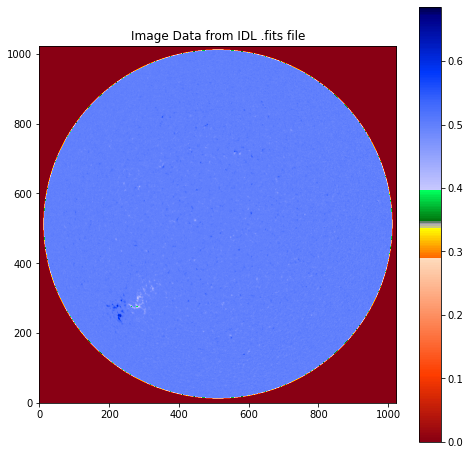

In [13]:
image_to_display = image_array[0, :, :]

plt.figure(figsize=(8, 8))
plt.imshow(image_to_display, cmap='hmimag', origin='lower')  # Use cmap='gray' for grayscale images
plt.colorbar()
plt.title('Image Data from IDL .fits file')
plt.show()

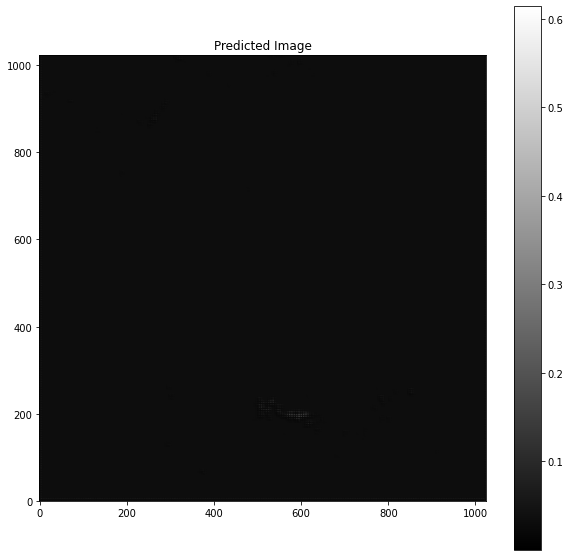

In [44]:
import matplotlib.pyplot as plt

# Remove the batch dimension and squeeze the channel dimension
image_to_display = prediction[0, :, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(image_to_display, cmap='gray', origin='lower')  # Assuming the prediction is a grayscale image
plt.colorbar()
plt.title('Predicted Image')
plt.show()


In [24]:
from tensorflow.keras.layers import Input, Lambda, Conv2DTranspose, Cropping2D, concatenate, Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import tensorflow as tf

def create_simplified_unet(input_size=(1024, 1024, 1), pretrained_weights=None):
    inputs = Input(input_size)
    x = Lambda(lambda x: tf.tile(x, multiples=[1, 1, 1, 3]))(inputs)  # Convert to RGB

    # Simplified MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x, input_shape=(1024, 1024, 3))

    # Freeze the layers of MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False

    # Fewer layer names for skip connections
    layer_names = [
        "block_3_expand_relu",   # Example layer, adjust as needed
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create a simplified decoder
    x = base_model.output
    for filters, skip_layer in zip([256, 128], layers[::-1]):  # Adjust filters and layers as needed
        x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(x)

        # Calculate cropping for skip layer
        skip_size = skip_layer.shape[1:3]
        x_size = x.shape[1:3]
        crop_size = [(s - x_s) // 2 for s, x_s in zip(skip_size, x_size)]
        cropped_skip_layer = Cropping2D(cropping=(crop_size, crop_size))(skip_layer)
        x = concatenate([x, cropped_skip_layer])
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)

    # Adjust final upsampling steps
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)  # Example: Upsample to 512x512
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)  # Example: Upsample to 1024x1024
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)  # Upsample to 512x512
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)   # Upsample to 1024x1024

    # Output layer for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model
# Create the U-Net model
model2 = create_simplified_unet()

# Compile the model
model2.compile(optimizer='adam', loss=weighted_bce, metrics=['accuracy'])
# Summary of the model
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 1024, 1024,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 512, 32  864         ['lambda_3[0][0]']               
                                )                                                           

In [21]:
list_of_x_train_files = get_file_paths("G:\\Train\\X_train")
list_of_y_train_files = get_file_paths("G:\\BMR_Identification")
x_train_generator = sun_data_generator(list_of_x_train_files)
y_train_generator = image_data_generator(list_of_y_train_files)

# Combine them into a single generator for training
train_generator = combined_generator(x_train_generator, y_train_generator, batch_size=2)

# Calculate the steps per epoch (total_samples / batch_size)
steps_per_epoch = len(list_of_x_train_files) // 2

# Prepare your generators for validation
list_of_x_test_files = get_file_paths("G:\\Validation\\X_test")
list_of_y_test_files = get_file_paths("G:\\Validation\\Y_test")
x_test_generator = sun_data_generator(list_of_x_test_files)
y_test_generator = image_data_generator(list_of_y_test_files)

# Combine them into a single generator for validation
validation_generator = combined_generator(x_test_generator, y_test_generator, batch_size=2)

# Define validation steps if you haven't
validation_steps = len(list_of_x_test_files) // 2

# Train the model
history = model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Replace with the number of epochs you desire
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks = [early_stopping]
)


model2.save("G:\\Model\\my_model3.h5")

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'weighted_bce/binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "E:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\anaconda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "E:\anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "E:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "E:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "E:\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "E:\anaconda\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "E:\anaconda\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "E:\anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "E:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "E:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "E:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "E:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "E:\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "E:\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_11040\192598789.py", line 25, in <module>
      history = model2.fit(
    File "E:\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "E:\anaconda\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "E:\anaconda\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "E:\anaconda\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "E:\anaconda\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_11040\3475487631.py", line 9, in weighted_bce
      loss = bce(y_true, y_pred)
    File "E:\anaconda\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "E:\anaconda\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "E:\anaconda\lib\site-packages\keras\losses.py", line 1932, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "E:\anaconda\lib\site-packages\keras\backend.py", line 5247, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
Node: 'weighted_bce/binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node weighted_bce/binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_20154]